# Brain Tumor Detection Using a Convolutional Neural Network

## Import Necessary Modules

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [4]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

Test on image1 of Yes dataset

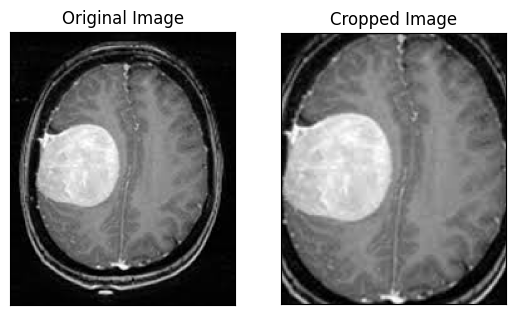

In [6]:
ex_img = cv2.imread('yes/Y1.jpg')
if ex_img is not None:
    ex_new_img = crop_brain_contour(ex_img, True)
else:
    print("Failed to read the image.")


### Load up the data:

In [7]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [14]:
augmented_path = "c:/users/dell/downloads/brain_tumor_dataset/augmented data/"

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 4232
X shape is: (4232, 240, 240, 3)
y shape is: (4232, 1)


Test:

In [15]:
def plot_sample_images(X, y, n=50):

    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

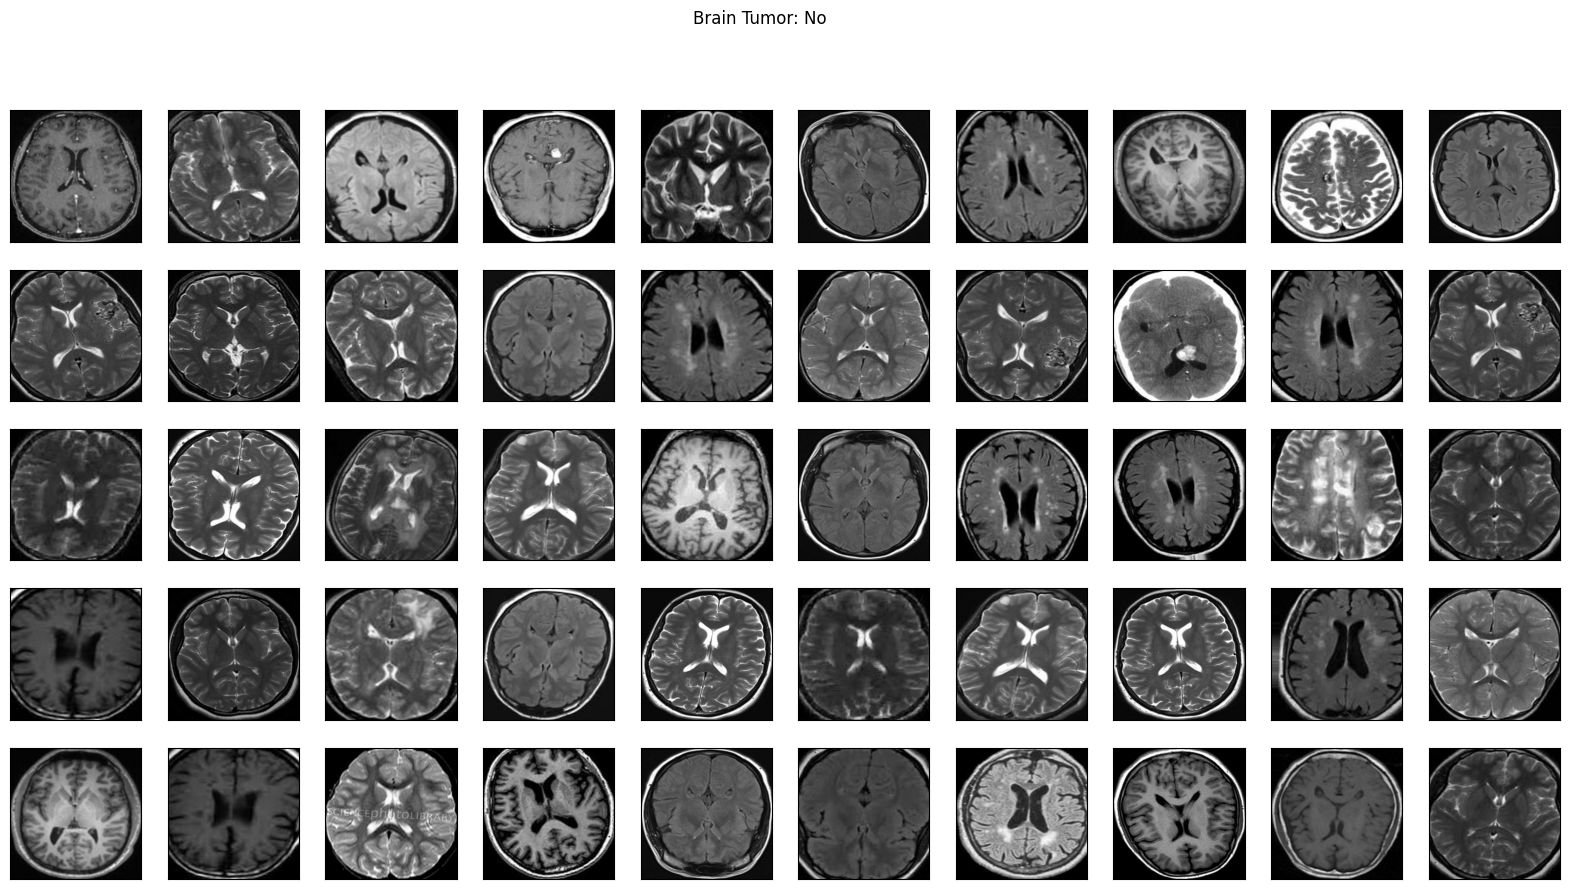

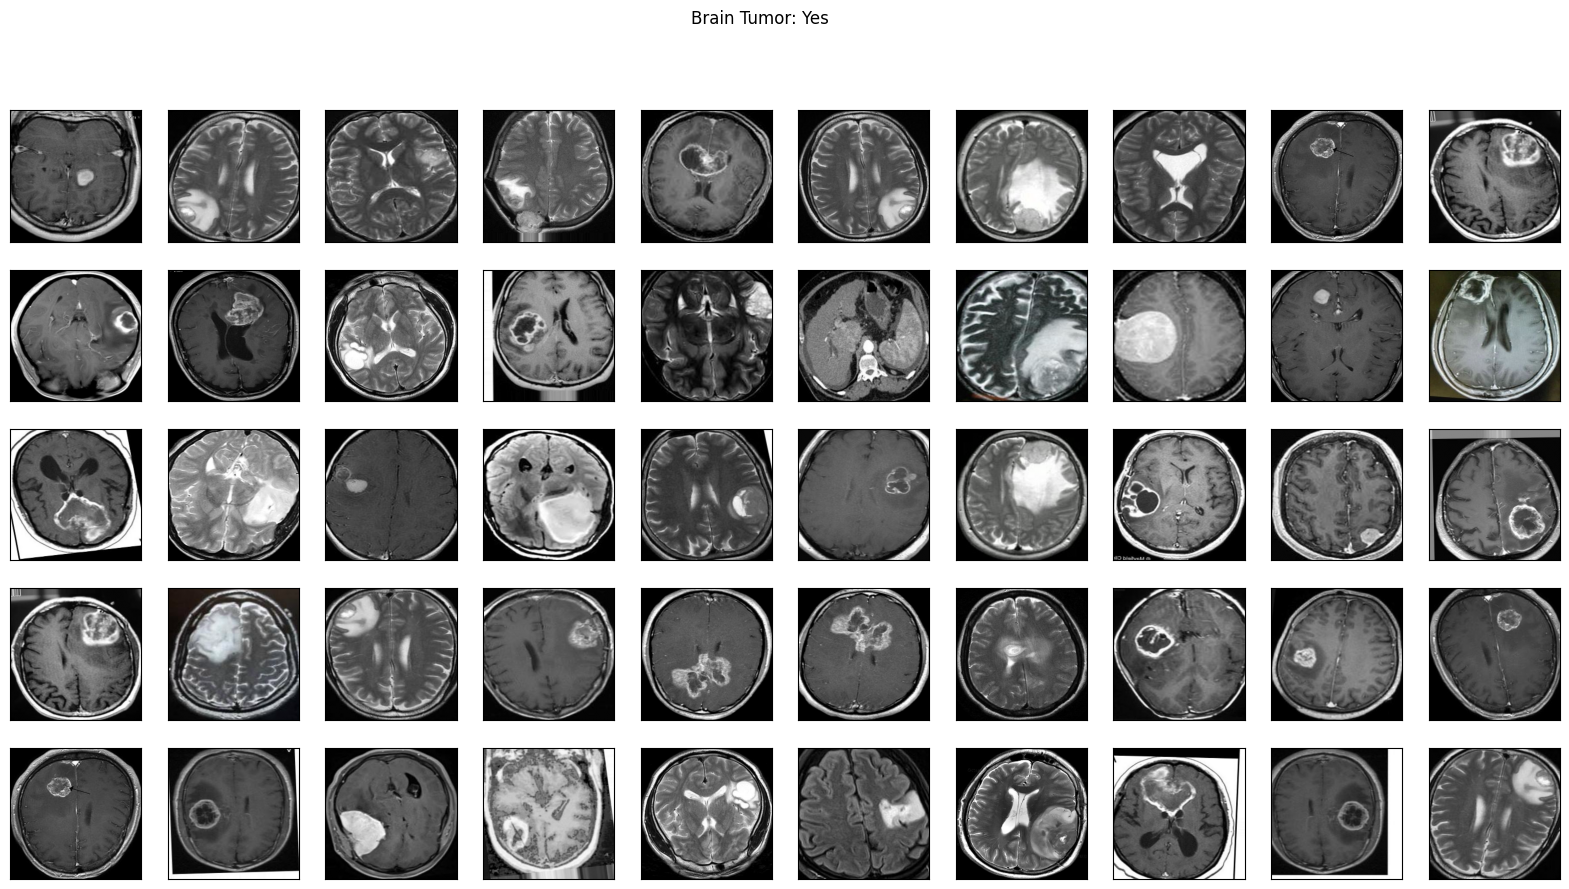

In [16]:
plot_sample_images(X, y)

### Split the data:


In [17]:
def split_data(X, y, test_size=0.2):    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
#using 70% of the data for training, and the rest for testing and validation
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [19]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2962
number of development examples = 635
number of test examples = 635
X_train shape: (2962, 240, 240, 3)
Y_train shape: (2962, 1)
X_val (dev) shape: (635, 240, 240, 3)
Y_val (dev) shape: (635, 1)
X_test shape: (635, 240, 240, 3)
Y_test shape: (635, 1)


Some helper functions:

In [20]:
"""print time for metrics"""
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [21]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [22]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [23]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [24]:
model = build_model(IMG_SHAPE)

In [25]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [34]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


## Train the model

In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.8818 - loss: 0.2907
Epoch 1: val_accuracy improved from -inf to 0.76063, saving model to models/cnn-parameters-improvement-01-0.76.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 714ms/step - accuracy: 0.8818 - loss: 0.2908 - val_accuracy: 0.7606 - val_loss: 0.5264
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.8750 - loss: 0.2878
Epoch 2: val_accuracy improved from 0.76063 to 0.86929, saving model to models/cnn-parameters-improvement-02-0.87.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 63s 680ms/step - accuracy: 0.8752 - loss: 0.2875 - val_accuracy: 0.8693 - val_loss: 0.3168
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9103 - loss: 0.2221
Epoch 3: val_accuracy did not improve from 0.86929
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 667ms/step - accuracy: 0.9102 - loss: 0.2225 - val_accuracy: 0.8693 - val_loss: 0.3203
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9048 - loss: 0.2359
Epoch 4: val_a

In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9684 - loss: 0.1003
Epoch 1: val_accuracy improved from -inf to 0.91496, saving model to models/cnn-parameters-improvement-01-0.91.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 722ms/step - accuracy: 0.9683 - loss: 0.1003 - val_accuracy: 0.9150 - val_loss: 0.2153
Epoch 2/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9637 - loss: 0.0982
Epoch 2: val_accuracy improved from 0.91496 to 0.91811, saving model to models/cnn-parameters-improvement-02-0.92.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 63s 682ms/step - accuracy: 0.9636 - loss: 0.0983 - val_accuracy: 0.9181 - val_loss: 0.2055
Epoch 3/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9802 - loss: 0.0775
Epoch 3: val_accuracy did not improve from 0.91811
93/93 ━━━━━━━━━━━━━━━━━━━━ 63s 672ms/step - accuracy: 0.9801 - loss: 0.0775 - val_accuracy: 0.8913 - val_loss: 0.2524
Elapsed time: 0:3:30.9


In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9663 - loss: 0.1039
Epoch 1: val_accuracy did not improve from 0.91811
93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 724ms/step - accuracy: 0.9662 - loss: 0.1040 - val_accuracy: 0.9039 - val_loss: 0.2367
Epoch 2/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9667 - loss: 0.0928
Epoch 2: val_accuracy did not improve from 0.91811
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 698ms/step - accuracy: 0.9666 - loss: 0.0929 - val_accuracy: 0.9087 - val_loss: 0.2512
Epoch 3/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9657 - loss: 0.0986
Epoch 3: val_accuracy did not improve from 0.91811
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 739ms/step - accuracy: 0.9657 - loss: 0.0986 - val_accuracy: 0.8063 - val_loss: 0.9123
Elapsed time: 0:3:42.2


In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9649 - loss: 0.1022
Epoch 1: val_accuracy did not improve from 0.91811
93/93 ━━━━━━━━━━━━━━━━━━━━ 72s 756ms/step - accuracy: 0.9650 - loss: 0.1021 - val_accuracy: 0.8441 - val_loss: 0.4474
Epoch 2/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9861 - loss: 0.0627
Epoch 2: val_accuracy did not improve from 0.91811
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 693ms/step - accuracy: 0.9861 - loss: 0.0627 - val_accuracy: 0.6441 - val_loss: 0.9769
Epoch 3/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9826 - loss: 0.0589
Epoch 3: val_accuracy improved from 0.91811 to 0.92126, saving model to models/cnn-parameters-improvement-03-0.92.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 70s 749ms/step - accuracy: 0.9826 - loss: 0.0589 - val_accuracy: 0.9213 - val_loss: 0.2085
Elapsed time: 0:3:45.0


In [39]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9906 - loss: 0.0493
Epoch 1: val_accuracy did not improve from 0.92126
93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 729ms/step - accuracy: 0.9906 - loss: 0.0494 - val_accuracy: 0.9071 - val_loss: 0.2505
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9866 - loss: 0.0520
Epoch 2: val_accuracy improved from 0.92126 to 0.94173, saving model to models/cnn-parameters-improvement-02-0.94.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 698ms/step - accuracy: 0.9866 - loss: 0.0520 - val_accuracy: 0.9417 - val_loss: 0.1811
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9882 - loss: 0.0487
Epoch 3: val_accuracy did not improve from 0.94173
93/93 ━━━━━━━━━━━━━━━━━━━━ 64s 691ms/step - accuracy: 0.9882 - loss: 0.0488 - val_accuracy: 0.8835 - val_loss: 0.3384
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9532 - loss: 0.1114
Epoch 4: val_accuracy did not improve from 0.94173
93/93 ━━━━━━━━━━━━━━━━━━━━ 64s 68

In [40]:
history = model.history.history

In [41]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [48]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

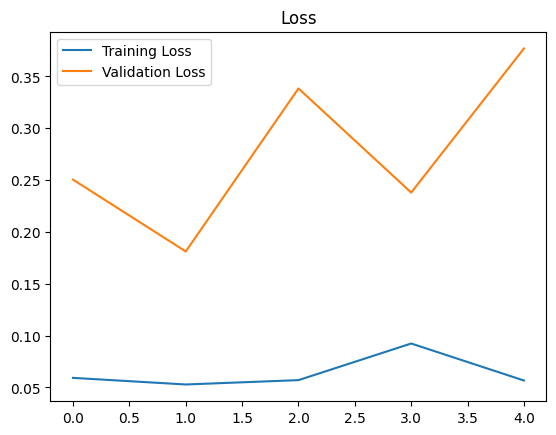

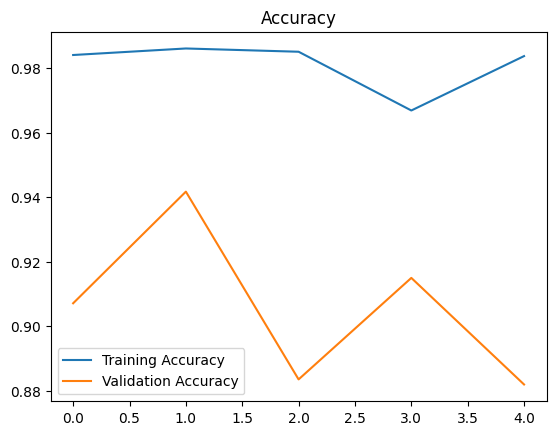

In [49]:
plot_metrics(history) 

# Results

In [54]:
best_model = load_model(filepath='models/cnn-parameters-improvement-03-0.92.keras')

In [55]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [56]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9192 - loss: 0.1949


### Accuracy of the best model on the testing data:

In [57]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.16667816042900085
Test Accuracy = 0.9338582754135132


In [67]:
loss, acc = best_model.evaluate(x=X_val, y=y_val)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9164 - loss: 0.2447
Test Loss = 0.20850534737110138
Test Accuracy = 0.9212598204612732


### F1 score for the best model on the testing data:

In [58]:
y_test_prob = best_model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


In [61]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9579158316633266


In [62]:
y_val_prob = best_model.predict(X_val)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step


In [63]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9496981891348089


# Conclusion:

The model detects brain tumor with:<br>
**93.38%** accuracy on the **test set**.<br>
**0.95** f1 score on the **test set**.<br>


**Performance Table:**

| Metric    | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 92.12%         | 93.38%   |
| F1 score  | 0.94           | 0.95     |